# Regularization and Evaluation of Neural Networks

In [6]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'scikeras'

In [5]:
# If you don't have scikeras installed, uncomment and run

# pip install scikeras
!pip install scikeras

     |████████████████████████████████| 10.1 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 22.6 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 0.17.0
    Uninstalling joblib-0.17.0:
      Successfully uninstalled joblib-0.17.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [7]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [8]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Metal device set to: Apple M1


2023-09-06 10:38:20.593975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-06 10:38:20.595780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2023-09-06 10:38:20.886980: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-06 10:38:21.125216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 2s 9ms/step - loss: 0.4567 - accuracy: 0.7947
Epoch 2/50
180/180 [==============================] - 1s 7ms/step - loss: 0.2579 - accuracy: 0.8993
Epoch 3/50
180/180 [==============================] - 1s 7ms/step - loss: 0.1919 - accuracy: 0.9265
Epoch 4/50
180/180 [==============================] - 1s 7ms/step - loss: 0.1577 - accuracy: 0.9416
Epoch 5/50
180/180 [==============================] - 1s 7ms/step - loss: 0.1273 - accuracy: 0.9460
Epoch 6/50
180/180 [==============================] - 1s 8ms/step - loss: 0.1096 - accuracy: 0.9605
Epoch 7/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0961 - accuracy: 0.9683
Epoch 8/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0784 - accuracy: 0.9733
Epoch 9/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0720 - accuracy: 0.9755
Epoch 10/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0675 - accuracy: 0.9750
Epoch 11/5

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs (not a HARD rule).
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [9]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [10]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10


2023-09-06 10:54:51.390459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 14ms/step - loss: 0.7338 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7254 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7189 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 8ms/step - loss: 0.7136 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7094 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7062 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7036 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7016 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7001 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 7ms/step - loss: 0.6990 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [11]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x1639149d0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7337544560432434,
   0.7254186272621155,
   0.718856692314148,
   0.7136024236679077,
   0.7093933820724487,
   0.7062188386917114,
   0.7036464810371399,
   0.7016388773918152,
   0.7001032829284668,
   0.6989659070968628],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

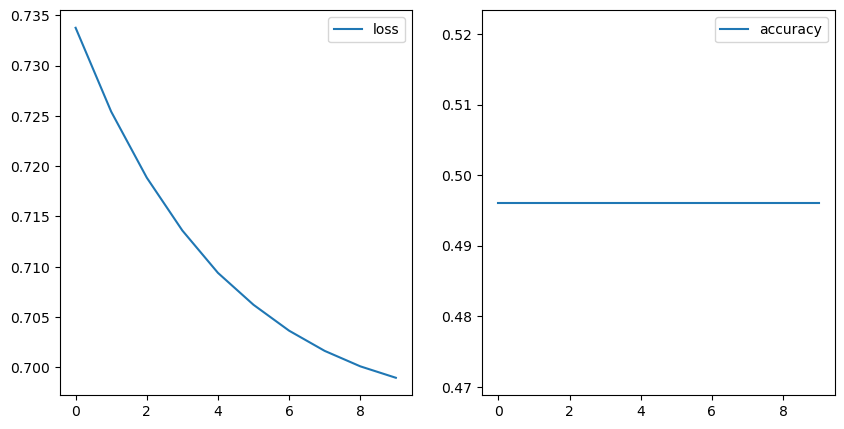

In [12]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [13]:
X_pure_train.shape[0]

1149

In [17]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
 7/36 [====>.........................] - ETA: 0s - loss: 0.7475 - accuracy: 0.5045

2023-09-06 10:58:31.363199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 9ms/step - loss: 0.7031 - accuracy: 0.4883
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6522 - accuracy: 0.6353
Epoch 3/100
36/36 [==============================] - 0s 9ms/step - loss: 0.6275 - accuracy: 0.6980
Epoch 4/100
36/36 [==============================] - 0s 9ms/step - loss: 0.6047 - accuracy: 0.7276
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.5810 - accuracy: 0.7415
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 0.5554 - accuracy: 0.7685
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.5294 - accuracy: 0.7789
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 0.5041 - accuracy: 0.7903
Epoch 9/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4795 - accuracy: 0.8007
Epoch 10/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4559 - accuracy: 0.8085
Epoch 11/100
36/36 [=

36/36 [==============================] - 0s 6ms/step - loss: 0.1294 - accuracy: 0.9487
Epoch 84/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1278 - accuracy: 0.9504
Epoch 85/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1276 - accuracy: 0.9504
Epoch 86/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1254 - accuracy: 0.9513
Epoch 87/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1249 - accuracy: 0.9539
Epoch 88/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1244 - accuracy: 0.9495
Epoch 89/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1228 - accuracy: 0.9513
Epoch 90/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1221 - accuracy: 0.9530
Epoch 91/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.9521
Epoch 92/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1197 - accuracy: 0.9521
Epoch 93/100


/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

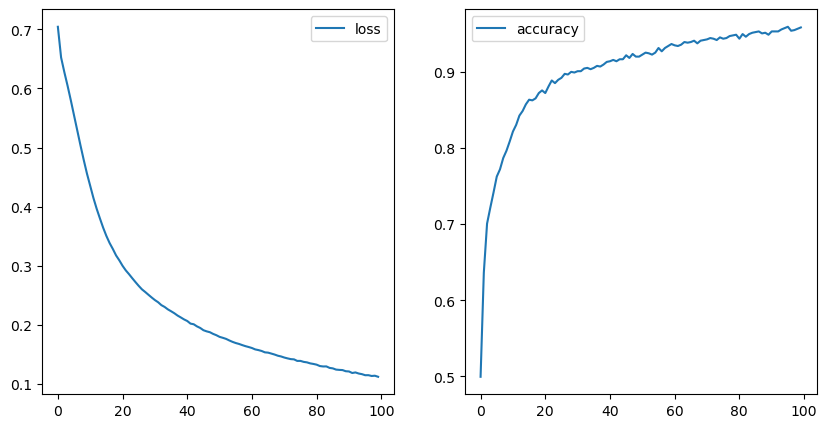

In [15]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
  9/115 [=>............................] - ETA: 0s - loss: 7.5559 - accuracy: 0.5222 

2023-09-06 10:55:22.049695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 1s 8ms/step - loss: 1.5593 - accuracy: 0.4848
Epoch 2/30
115/115 [==============================] - 1s 6ms/step - loss: 0.9666 - accuracy: 0.5100
Epoch 3/30
115/115 [==============================] - 1s 6ms/step - loss: 0.9714 - accuracy: 0.4978
Epoch 4/30
115/115 [==============================] - 1s 6ms/step - loss: 0.9821 - accuracy: 0.5100
Epoch 5/30
115/115 [==============================] - 1s 7ms/step - loss: 0.9583 - accuracy: 0.4978
Epoch 6/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0732 - accuracy: 0.4978
Epoch 7/30
115/115 [==============================] - 1s 6ms/step - loss: 0.8762 - accuracy: 0.5292
Epoch 8/30
115/115 [==============================] - 1s 6ms/step - loss: 0.9816 - accuracy: 0.5022
Epoch 9/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0132 - accuracy: 0.4909
Epoch 10/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0508 - accuracy: 0.4778
Epoch 11/3

/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

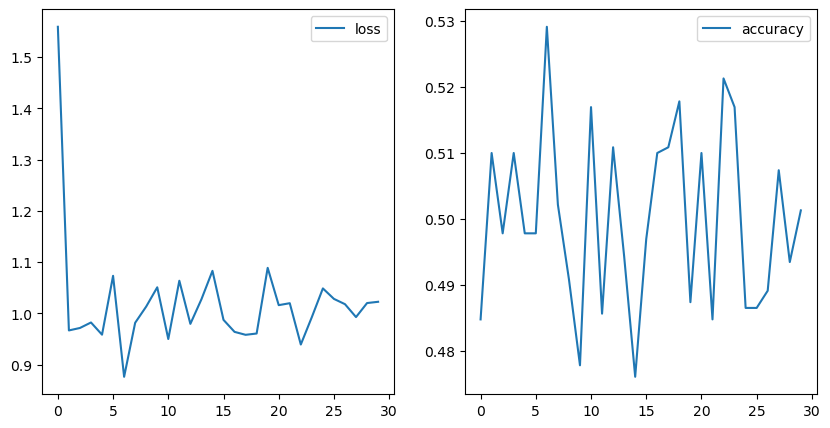

In [16]:
model = Sequential()

sgd = SGD(learning_rate=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
 1/36 [..............................] - ETA: 21s - loss: 0.7901 - accuracy: 0.4062

2023-09-06 11:10:46.112551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 14ms/step - loss: 0.6970 - accuracy: 0.5352 - val_loss: 0.6599 - val_accuracy: 0.6076
Epoch 2/30
 7/36 [====>.........................] - ETA: 0s - loss: 0.6472 - accuracy: 0.6250

2023-09-06 11:10:46.687772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 9ms/step - loss: 0.6060 - accuracy: 0.6963 - val_loss: 0.5888 - val_accuracy: 0.7222
Epoch 3/30
36/36 [==============================] - 0s 9ms/step - loss: 0.5206 - accuracy: 0.7789 - val_loss: 0.4961 - val_accuracy: 0.7812
Epoch 4/30
36/36 [==============================] - 0s 9ms/step - loss: 0.4299 - accuracy: 0.8329 - val_loss: 0.4026 - val_accuracy: 0.8438
Epoch 5/30
36/36 [==============================] - 0s 8ms/step - loss: 0.3466 - accuracy: 0.8660 - val_loss: 0.3347 - val_accuracy: 0.8611
Epoch 6/30
36/36 [==============================] - 0s 8ms/step - loss: 0.2997 - accuracy: 0.8755 - val_loss: 0.2980 - val_accuracy: 0.8819
Epoch 7/30
36/36 [==============================] - 0s 8ms/step - loss: 0.2639 - accuracy: 0.8886 - val_loss: 0.2679 - val_accuracy: 0.8819
Epoch 8/30
36/36 [==============================] - 0s 9ms/step - loss: 0.2464 - accuracy: 0.8964 - val_loss: 0.2664 - val_accuracy: 0.8924
Epoch 9/30
36/36 [=============

/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

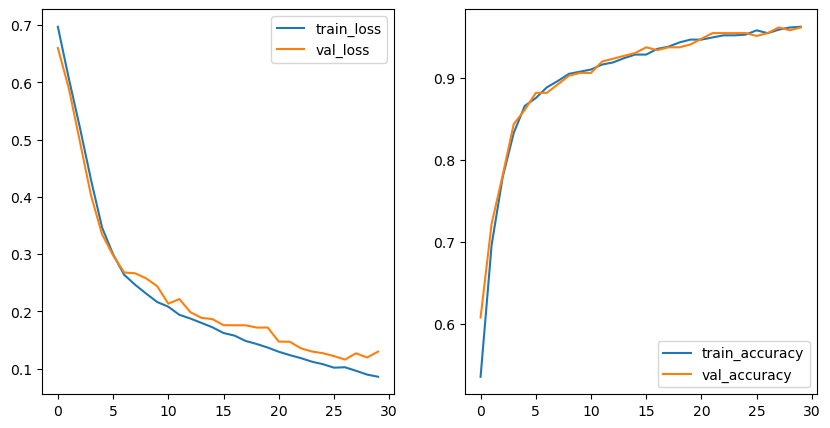

In [20]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [21]:
results.history['val_accuracy'][-1]

0.9618055820465088

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [22]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x29195db50> does not.

In [23]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [24]:
keras_model = KerasClassifier(build_model,
                              epochs=50,
                              batch_size=32,
                              verbose=2)

NameError: name 'KerasClassifier' is not defined

In [25]:
type(keras_model)

NameError: name 'keras_model' is not defined

In [26]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

NameError: name 'keras_model' is not defined

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

Epoch 1/20


2023-09-06 11:30:36.988323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 2s 20ms/step - loss: 1.7175 - accuracy: 0.6310 - val_loss: 1.5227 - val_accuracy: 0.7083
Epoch 2/20
 1/36 [..............................] - ETA: 0s - loss: 1.5042 - accuracy: 0.7812

2023-09-06 11:30:38.516841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 9ms/step - loss: 1.3210 - accuracy: 0.7711 - val_loss: 1.1231 - val_accuracy: 0.8299
Epoch 3/20
36/36 [==============================] - 0s 10ms/step - loss: 0.9377 - accuracy: 0.8686 - val_loss: 0.8503 - val_accuracy: 0.8715
Epoch 4/20
36/36 [==============================] - 0s 10ms/step - loss: 0.6905 - accuracy: 0.9017 - val_loss: 0.5937 - val_accuracy: 0.9236
Epoch 5/20
36/36 [==============================] - 0s 10ms/step - loss: 0.5211 - accuracy: 0.9382 - val_loss: 0.4762 - val_accuracy: 0.9479
Epoch 6/20
36/36 [==============================] - 0s 9ms/step - loss: 0.4157 - accuracy: 0.9487 - val_loss: 0.4260 - val_accuracy: 0.9479
Epoch 7/20
36/36 [==============================] - 0s 9ms/step - loss: 0.3323 - accuracy: 0.9626 - val_loss: 0.3610 - val_accuracy: 0.9479
Epoch 8/20
36/36 [==============================] - 0s 9ms/step - loss: 0.2837 - accuracy: 0.9695 - val_loss: 0.2908 - val_accuracy: 0.9618
Epoch 9/20
36/36 [==========

/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

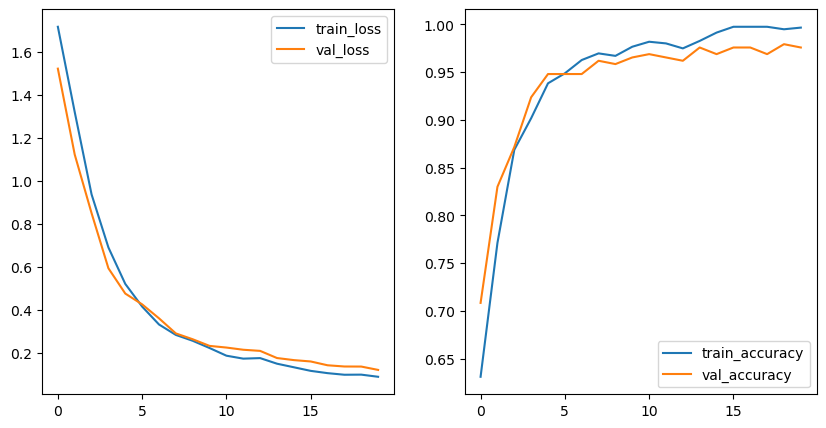

In [27]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=1, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

2023-09-06 11:30:45.542456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-06 11:30:46.402691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

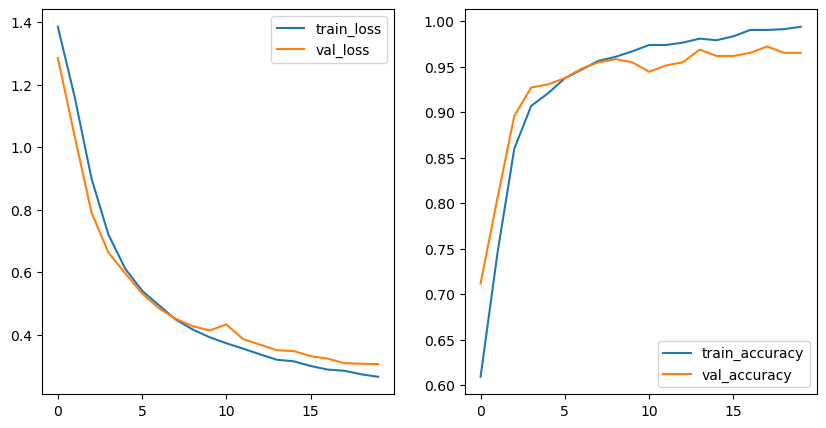

In [28]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

Epoch 1/50


2023-09-06 11:36:54.773672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 2s 30ms/step - loss: 0.6899 - accuracy: 0.5631 - val_loss: 0.6619 - val_accuracy: 0.6944
Epoch 2/50
 1/36 [..............................] - ETA: 0s - loss: 0.6965 - accuracy: 0.4688

2023-09-06 11:36:56.066661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 10ms/step - loss: 0.6472 - accuracy: 0.6240 - val_loss: 0.6054 - val_accuracy: 0.6979
Epoch 3/50
36/36 [==============================] - 0s 11ms/step - loss: 0.5662 - accuracy: 0.7215 - val_loss: 0.4551 - val_accuracy: 0.8125
Epoch 4/50
36/36 [==============================] - 0s 10ms/step - loss: 0.4310 - accuracy: 0.8068 - val_loss: 0.3215 - val_accuracy: 0.8681
Epoch 5/50
36/36 [==============================] - 0s 10ms/step - loss: 0.3502 - accuracy: 0.8460 - val_loss: 0.2647 - val_accuracy: 0.8924
Epoch 6/50
36/36 [==============================] - 0s 10ms/step - loss: 0.3169 - accuracy: 0.8634 - val_loss: 0.2592 - val_accuracy: 0.9132
Epoch 7/50
36/36 [==============================] - 0s 10ms/step - loss: 0.2765 - accuracy: 0.8912 - val_loss: 0.2235 - val_accuracy: 0.9167
Epoch 8/50
36/36 [==============================] - 0s 9ms/step - loss: 0.2448 - accuracy: 0.8912 - val_loss: 0.1990 - val_accuracy: 0.9271
Epoch 9/50
36/36 [=======

/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

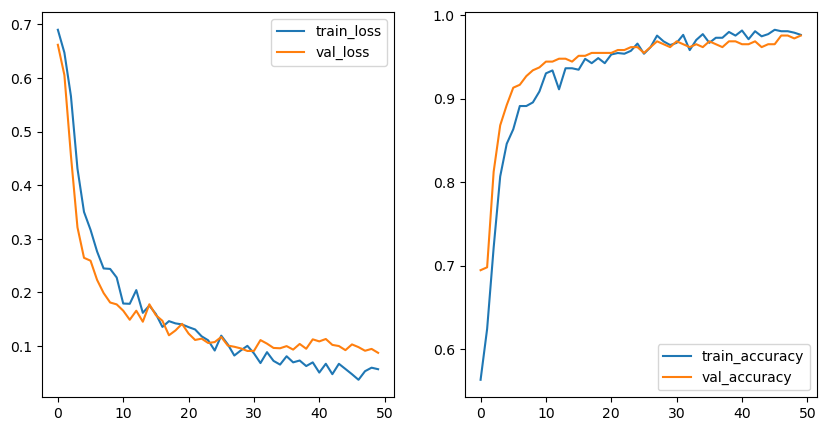

In [31]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dropout(rate=.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=1,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [32]:
results.history['val_accuracy'][-1]

0.9756944179534912

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

2023-09-06 11:30:53.560248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-06 11:30:54.445827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2: early stopping


/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

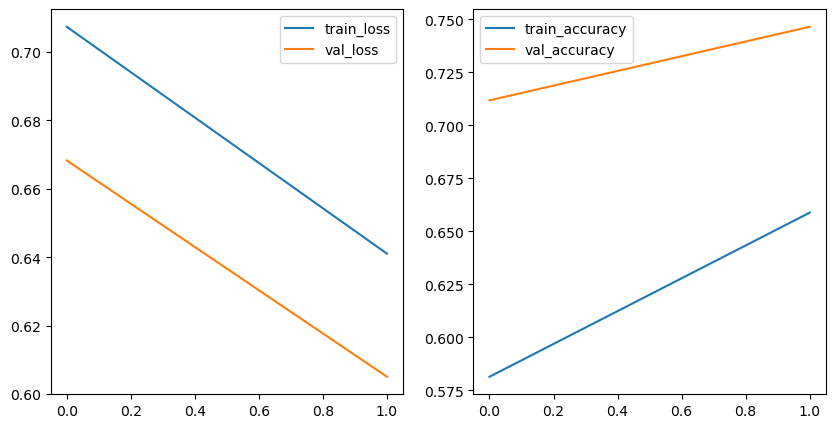

In [29]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

2023-09-06 11:46:37.360187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-06 11:46:38.242994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

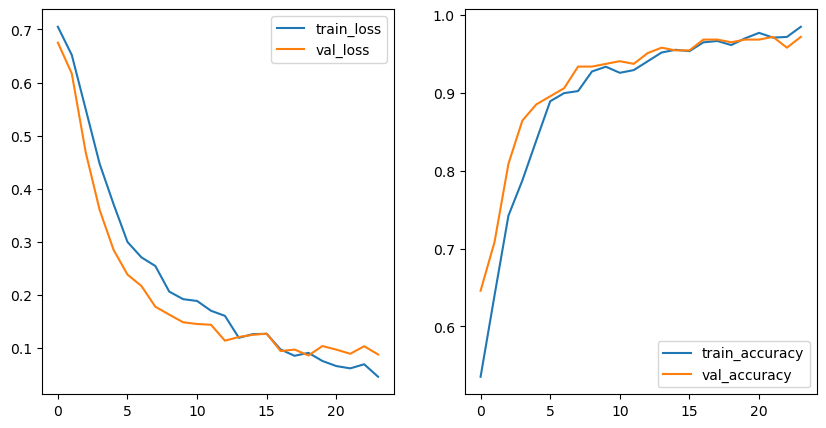

In [33]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [ ]:
results.history['val_accuracy'][-1]

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [34]:
digits = load_digits()
X = digits.data
y = digits.target

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [36]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50


2023-09-06 11:54:19.306456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 2.1375 - accuracy: 0.1932

2023-09-06 11:54:21.685223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 3s 15ms/step - loss: 2.1375 - accuracy: 0.1932 - val_loss: 2.0281 - val_accuracy: 0.2951
Epoch 2/50
115/115 [==============================] - 1s 11ms/step - loss: 1.8528 - accuracy: 0.4125 - val_loss: 1.7674 - val_accuracy: 0.3924
Epoch 3/50
115/115 [==============================] - 1s 11ms/step - loss: 1.5696 - accuracy: 0.5117 - val_loss: 1.5005 - val_accuracy: 0.5069
Epoch 4/50
115/115 [==============================] - 1s 11ms/step - loss: 1.2831 - accuracy: 0.6440 - val_loss: 1.2038 - val_accuracy: 0.6667
Epoch 5/50
115/115 [==============================] - 1s 12ms/step - loss: 0.9906 - accuracy: 0.7615 - val_loss: 0.9209 - val_accuracy: 0.8021
Epoch 6/50
115/115 [==============================] - 1s 11ms/step - loss: 0.7733 - accuracy: 0.8155 - val_loss: 0.7231 - val_accuracy: 0.8229
Epoch 7/50
115/115 [==============================] - 1s 11ms/step - loss: 0.6197 - accuracy: 0.8555 - val_loss: 0.6105 - val_accuracy: 0.8472
Epoch 8/50

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [39]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/robertdaly/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

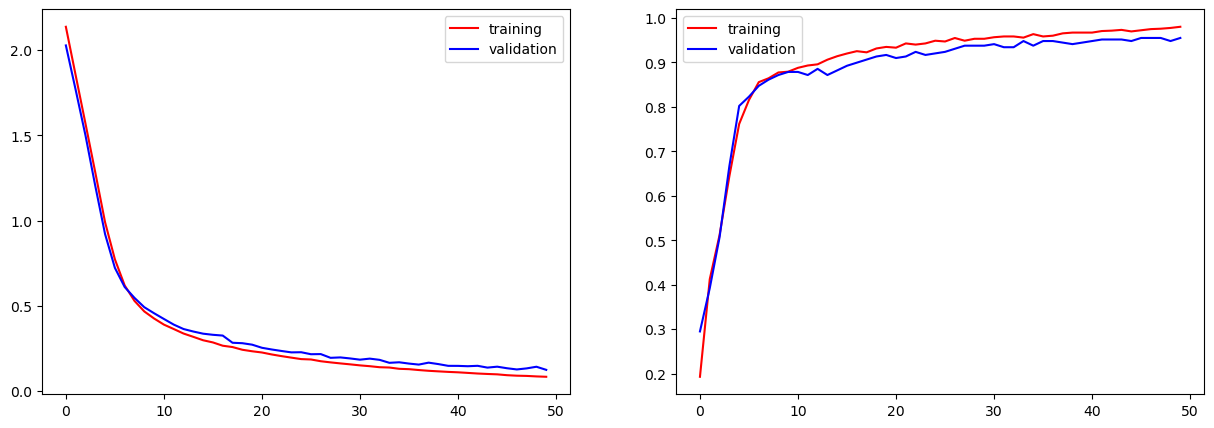

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [41]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

12/12 [==============================] - 0s 4ms/step


2023-09-06 11:56:30.279393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [42]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 27,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 29,  2,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  1, 32,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 43,  0,  0,  1,  3],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  1,  0,  0,  1,  0,  0, 26,  1],
       [ 0,  0,  0,  2,  0,  1,  0,  1,  0, 36]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools this afternoon.


In [48]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
sk_model = KerasClassifier(build_model, epochs=50, batch_size=32, verbose=2)
type(sk_model)

/var/folders/bw/cbvdf59j1dx21l0n3ftr5b040000gn/T/ipykernel_42113/3311157567.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sk_model = KerasClassifier(build_model, epochs=50, batch_size=32, verbose=2)


keras.wrappers.scikit_learn.KerasClassifier

In [47]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
keras_model = KerasClassifier(build_model, epochs=50, batch_size=32, verbose=2)

/var/folders/bw/cbvdf59j1dx21l0n3ftr5b040000gn/T/ipykernel_42113/2771731043.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_model, epochs=50, batch_size=32, verbose=2)


In [ ]:
sk_model=sci